# Explore here

It's recommended to use this notebook for exploration purposes.

In [23]:
import pandas as pd
import sqlite3
import requests
from bs4 import BeautifulSoup
import matplotlib.pyplot as plt
from urllib.request import Request, urlopen
import seaborn as sns

In [3]:
resource_url = "https://www.macrotrends.net/stocks/charts/TSLA/tesla/revenue"

response = requests.get(resource_url).text

if "403 Forbidden" in response:
    headers = {"User-Agent": "Mozilla/5.0 (Macintosh; Intel Mac OS X 10_11_5) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/50.0.2661.102 Safari/537.36"}
    request = requests.get(resource_url, headers = headers)
    response = request.text




In [4]:
soup = BeautifulSoup(response,'html.parser')

soup


<!DOCTYPE html>

<!--[if lt IE 7]>      <html class="no-js lt-ie9 lt-ie8 lt-ie7"> <![endif]-->
<!--[if IE 7]>         <html class="no-js lt-ie9 lt-ie8"> <![endif]-->
<!--[if IE 8]>         <html class="no-js lt-ie9"> <![endif]-->
<!--[if gt IE 8]><!--> <html class="no-js"> <!--<![endif]-->
<head>
<meta charset="utf-8"/>
<meta content="IE=edge,chrome=1" http-equiv="X-UA-Compatible"/>
<link href="https://www.macrotrends.net/stocks/charts/TSLA/tesla/revenue" rel="canonical"/>
<title>Tesla Revenue 2010-2023 | TSLA | MacroTrends</title>
<link href="/assets/images/icons/FAVICON/macrotrends-favicon.ico" rel="icon" type="image/x-icon"/>
<meta content="Tesla annual/quarterly revenue history and growth rate from 2010 to 2023. Revenue can be defined as the amount of money a company receives from its customers in exchange for the sales of goods or services.  Revenue is the top line item on an income statement from which all costs and expenses are subtracted to arrive at net income.    
				
				&

In [5]:
tablas = soup.find_all('table')

tablas

[<table class="historical_data_table table">
 <thead>
 <tr>
 <th colspan="2" style="text-align:center">Tesla Annual Revenue<br/><span style="font-size:14px;">(Millions of US $)</span></th>
 </tr>
 </thead>
 <tbody>
 <tr>
 <td style="text-align:center">2022</td>
 <td style="text-align:center">$81,462</td>
 </tr>
 <tr>
 <td style="text-align:center">2021</td>
 <td style="text-align:center">$53,823</td>
 </tr>
 <tr>
 <td style="text-align:center">2020</td>
 <td style="text-align:center">$31,536</td>
 </tr>
 <tr>
 <td style="text-align:center">2019</td>
 <td style="text-align:center">$24,578</td>
 </tr>
 <tr>
 <td style="text-align:center">2018</td>
 <td style="text-align:center">$21,461</td>
 </tr>
 <tr>
 <td style="text-align:center">2017</td>
 <td style="text-align:center">$11,759</td>
 </tr>
 <tr>
 <td style="text-align:center">2016</td>
 <td style="text-align:center">$7,000</td>
 </tr>
 <tr>
 <td style="text-align:center">2015</td>
 <td style="text-align:center">$4,046</td>
 </tr>
 <t

In [6]:
# Empezamos un bucle para recorrer todas las 'tablas' en la lista llamada 'tablas'.
# El 'enumerate' nos da el número de posición (index) y el objeto de tabla actual.
for index, tabla in enumerate(tablas):

    # Verifica si la frase 'Tesla Quarterly Revenue' está presente en la tabla actual.
    if ('Tesla Quarterly Revenue' in str(tabla)):
        
        # Si encontramos la tabla correcta, guardamos su posición en 'indice_tabla'.
        indice_tabla = index
        
        # Salimos del bucle ya que encontramos lo que buscábamos.
        break

# Creamos un DataFrame vacío llamado 'trimestral' con columnas "Fecha" y "Renovar".
trimestral = pd.DataFrame(columns= ["Fecha", "Renovar"])

# Ahora recorremos cada fila de la tabla de 'Tesla Quarterly Revenue'.
for fila in tablas[indice_tabla].tbody.find_all('tr'):
    
    # Para cada fila, extraemos todas las celdas (columnas) que contiene.
    columna = fila.find_all('td')
    
    # Verificamos si la fila tiene celdas.
    if (columna != []):
        
        # Si tiene celdas, tomamos el texto de la primera celda como 'datos'.
        datos = columna[0].text
        
        # Tomamos el texto de la segunda celda, eliminamos símbolos de dólar y comas, y lo guardamos como 'renovar'.
        renovar = columna[1].text.replace("$","").replace(",","")
        
        # Añadimos esta nueva fila al DataFrame 'trimestral'.
        trimestral = pd.concat([trimestral, pd.DataFrame({"Fecha": datos, "Renovar": renovar}, index=[0])], ignore_index=True)

# Finalmente, mostramos las primeras filas del DataFrame 'trimestral' para ver lo que contiene.
trimestral.head()

,Fecha,Renovar
0,2023-06-30,24927
1,2023-03-31,23329
2,2022-12-31,24318
3,2022-09-30,21454
4,2022-06-30,16934


In [7]:
# Intenta conectarse a la base de datos 'tesla.db'. Si no existe, la crea.
conexion = sqlite3.connect('tesla.db')

# Si la conexión fue exitosa, imprime un mensaje de confirmación.
if conexion:
    print('Base de datos conectada.')

# Crea un cursor. El cursor permite ejecutar consultas SQL en la base de datos.
cursor = conexion.cursor()

# Si la tabla 'renovar' no existe en la base de datos, la crea.
# Define dos columnas: 'Fecha' y 'Renovar', ambas para almacenar texto.
cursor.execute("""CREATE TABLE IF NOT EXISTS renovar (Fecha TEXT, Renovar TEXT)""")

# Convierte el DataFrame 'trimestral' a una lista de registros/tuplas.
listas = list(trimestral.to_records(index=False))

# Muestra los primeros 5 registros de la lista (esto no afecta la inserción de datos).
listas[:5]

# Inserta todos los registros de la lista en la tabla 'renovar'.
cursor.executemany("""INSERT INTO Renovar VALUES (?,?)""", listas)

# Guarda (commit) los cambios realizados en la base de datos.
conexion.commit()

# Recupera y muestra todos los registros de la tabla 'renovar'.
for datos in cursor.execute("""SELECT * FROM renovar"""):
    print(datos)

Base de datos conectada.
('2023-06-30', '24927')
('2023-03-31', '23329')
('2022-12-31', '24318')
('2022-09-30', '21454')
('2022-06-30', '16934')
('2022-03-31', '18756')
('2021-12-31', '17719')
('2021-09-30', '13757')
('2021-06-30', '11958')
('2021-03-31', '10389')
('2020-12-31', '10744')
('2020-09-30', '8771')
('2020-06-30', '6036')
('2020-03-31', '5985')
('2019-12-31', '7384')
('2019-09-30', '6303')
('2019-06-30', '6350')
('2019-03-31', '4541')
('2018-12-31', '7226')
('2018-09-30', '6824')
('2018-06-30', '4002')
('2018-03-31', '3409')
('2017-12-31', '3288')
('2017-09-30', '2985')
('2017-06-30', '2790')
('2017-03-31', '2696')
('2016-12-31', '2285')
('2016-09-30', '2298')
('2016-06-30', '1270')
('2016-03-31', '1147')
('2015-12-31', '1214')
('2015-09-30', '937')
('2015-06-30', '955')
('2015-03-31', '940')
('2014-12-31', '957')
('2014-09-30', '852')
('2014-06-30', '769')
('2014-03-31', '621')
('2013-12-31', '615')
('2013-09-30', '431')
('2013-06-30', '405')
('2013-03-31', '562')
('2012-12

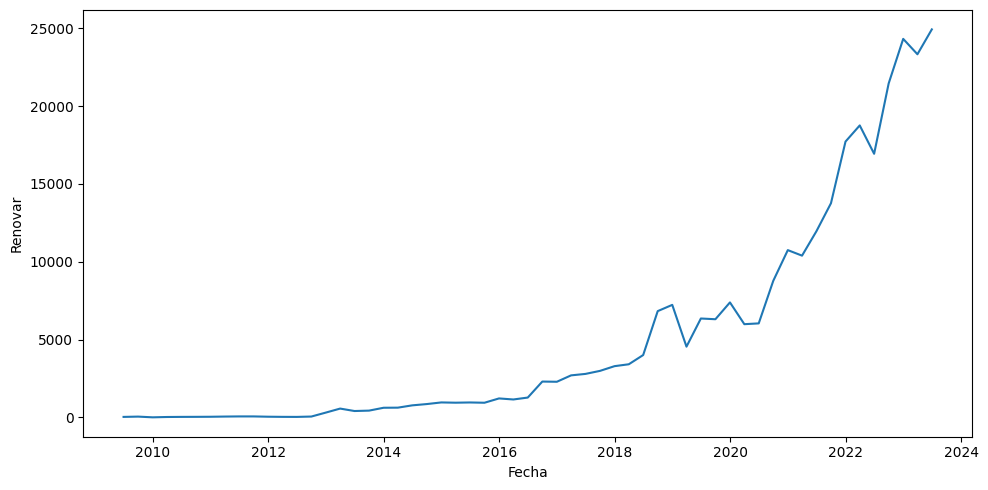

In [30]:
# Crear una nueva figura y ejes con un tamaño específico de 10x5 pulgadas.
fig, axis = plt.subplots(figsize = (10, 5))

# Convertir la columna "Fecha" del DataFrame 'trimestral' al tipo datetime.
trimestral["Fecha"] = pd.to_datetime(trimestral["Fecha"])

# Reemplazar cualquier cadena vacía en la columna "Renovar" con '0', y luego convertir toda la columna a tipo entero.
trimestral["Renovar"] = trimestral["Renovar"].replace('', '0').astype('int')

# Dibujar un gráfico de línea utilizando la columna "Fecha" como eje x y la columna "Renovar" como eje y.
sns.lineplot(data = trimestral, x = "Fecha", y = "Renovar")

# Ajustar el diseño para que todo encaje bien y no haya superposiciones.
plt.tight_layout()

# Mostrar el gráfico.
plt.show()



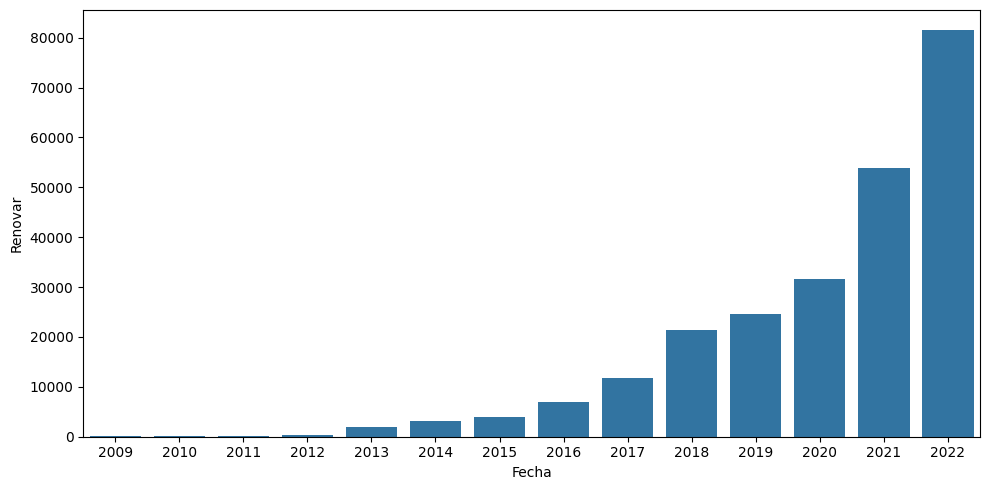

In [36]:
# Crear una nueva figura y ejes con un tamaño específico de 10x5 pulgadas.
fig, axis = plt.subplots(figsize= (10, 5))

# Convertir la columna "Fecha" del DataFrame 'trimestral' al tipo datetime.
trimestral['Fecha'] = pd.to_datetime(trimestral['Fecha'])

# Agrupar el DataFrame 'trimestral' por el año de la columna "Fecha" y sumar los valores de 'Renovar' para cada año.
# Luego, resetear los índices del DataFrame resultante para que el año sea una columna y no el índice.
trimestral_fecha = trimestral.groupby(trimestral['Fecha'].dt.year).sum().reset_index()

# Crear un gráfico de barras utilizando el año (columna "Fecha") como eje x y la suma de 'Renovar' como eje y.
# Solo se consideran los años anteriores a 2023.
sns.barplot(data = trimestral_fecha[trimestral_fecha['Fecha'] < 2023], x= 'Fecha', y= 'Renovar')

# Ajustar el diseño para que todo encaje bien y no haya superposiciones.
plt.tight_layout()

# Mostrar el gráfico.
plt.show()


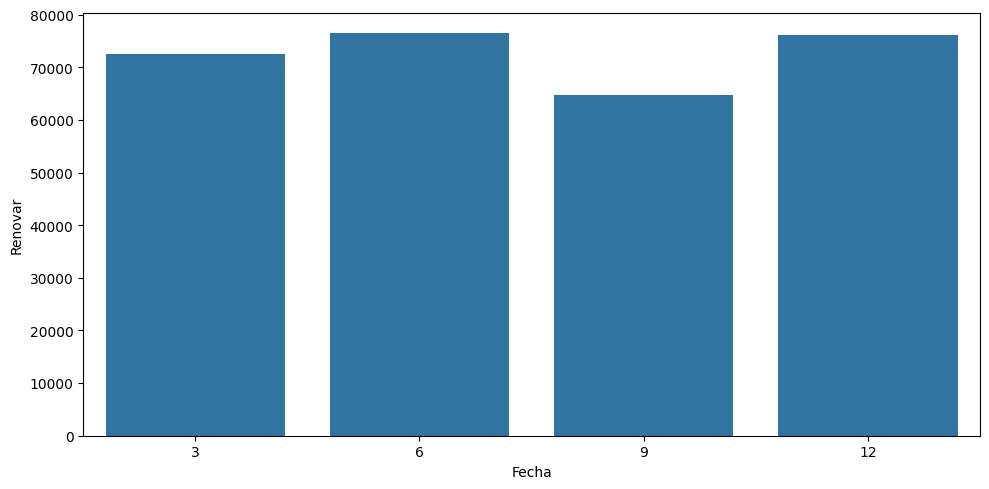

In [38]:
# Crear una nueva figura y ejes con un tamaño específico de 10x5 pulgadas.
fig, axis = plt.subplots(figsize = (10, 5))

# Agrupar el DataFrame 'trimestral' por el mes de la columna "Fecha" y sumar los valores de 'Renovar' para cada mes.
# Luego, resetear los índices del DataFrame resultante para que el mes sea una columna y no el índice.
trimestral_mes = trimestral.groupby(trimestral['Fecha'].dt.month).sum().reset_index()

# Crear un gráfico de barras utilizando el mes (columna "Fecha") como eje x y la suma de 'Renovar' como eje y.
sns.barplot(data= trimestral_mes, x= 'Fecha', y= 'Renovar')

# Ajustar el diseño para que todo encaje bien y no haya superposiciones.
plt.tight_layout()

# Mostrar el gráfico.
plt.show()